# Introduction to backtesting trading strategies using `zipline`

Learn how to build and backtest trading strategies using `zipline`

## Introduction

In this article, I would like to continue the series on quantitative finance. In the [first part](https://towardsdatascience.com/introduction-to-quantitative-finance-part-i-stylised-facts-of-asset-returns-5190581e40ea), I described the stylized facts of asset returns. Now I would like to introduce the concept of backtesting trading strategies and how to do it using existing frameworks in Python.

## What is backtesting?

Let's start with a trading strategy. It can be defined as a method of buying and/or selling assets in markets that is based on predefined rules. These rules can be based on, for example, technical analysis or machine learning models.

Backtesting is basically evaluating the performance of a trading strategy on historical data - if we used a given strategy on a set of assets in the past, how well/bad would it have performed. Of course, there is no guarantee that past performance is indicative of the future one, but we can still investigate!

There are a few available frameworks for backtesting in Python, in this article, I decided to use `zipline`.

## Why zipline?

Some of the nice features offered by the `zipline` environment include:
* ease of use - there is a clear structure of how to build a backtest and what outcome we can expect, so the majority of the time can be spent on developing state-of-the-art trading strategies :)
* realistic - includes transaction costs, slippage, order delays, etc.
* stream-based - processes each event individually, thus avoids look-ahead bias
* it comes with many easily-accessible statistical measures, such as moving average, linear regression, etc. - no need to code them from scratch
* integration with PyData ecosystem - `zipline` uses Pandas DataFrames for storing input data, as well as performance metrics
* it is easy to integrate other libraries, such as `matplotlib`, `scipy`, `statsmodels` and `sklearn` into the workflow of building and evaluating strategies
* developed and updated by Quantopian which provides a web-interface for `zipline`, historical data and even live-trading capabilities

I believe these arguments speak for themselves. Let's start coding!

## Setting up the virtual environment using conda

The most convenient way to install `zipline` is to use a virtual environment. In this article, I use `conda` to do so. I create a new environment with Python 3.5 (I experienced issues with using 3.6 or 3.7) and then install `zipline`. You can also `pip install` it.

In [ ]:
# create new virtual environment
conda create -n env_zipline python=3.5

# activate it
conda activate env_zipline

# install zipline
conda install -c Quantopian zipline

For everything to be working properly you should also install `jupyter` and other packages used in this article (see the `watermark` printout below).

## Importing libraries

First, we need to load IPython extensions using the `%load_ext` magic.

In [1]:
%load_ext watermark

In [2]:
%load_ext zipline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Then we import the rest of the libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from trading_calendars import get_calendar
from yahoofinancials import YahooFinancials
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

Below you can see the list of libraries used in this article, together with their versions.

In [5]:
%watermark --iversions

numpy      1.14.6
zipline    1.3.0
pandas     0.22.0
matplotlib 3.0.0
json       2.0.9



## Import custom data

`zipline` comes ready with data downloaded from Quandl (the WIKI database). You can always inspect the already ingested data by running: 

In [10]:
!zipline bundles

csvdir <no ingestions>
eu_stocks <no ingestions>
quandl 2019-04-22 11:07:43.501513
quandl 2019-04-22 11:00:47.961243
quantopian-quandl <no ingestions>


The issue with this approach is that in mid-2018 the data was discontinued, so there is no data for the last year. Additionally, the Quandl dataset only covers US stocks. In this article we want to build simple strategies based on EU stocks. That is why we have to manually ingest data from another source. To do so I use the `yahoofinancials` library. In order to be loaded into `zipline`, the data must be in a CSV file and in a predefined format, which can be inspected below. For this article we download two securities: stock prices of ABN AMRO (a Dutch bank) and the AEX (a stock market index composed of Dutch companies that trade on Euronext Amsterdam). We use the latter one as the benchmark.

First, we define a short function for downloading the data using `yahoofinancials` and preparing the `DataFrame` in a way it can be ingested by `zipline`. After preparing the data, we save the data as a CSV file in a folder called `daily` (or another folder of your choice).

It is possible to pass multiple tickers to `yahoofinancials` and download them all at once, however, we chose this way for simplicity of the required manipulations.

In [7]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

We begin by downloading the ABN AMRO stock prices.

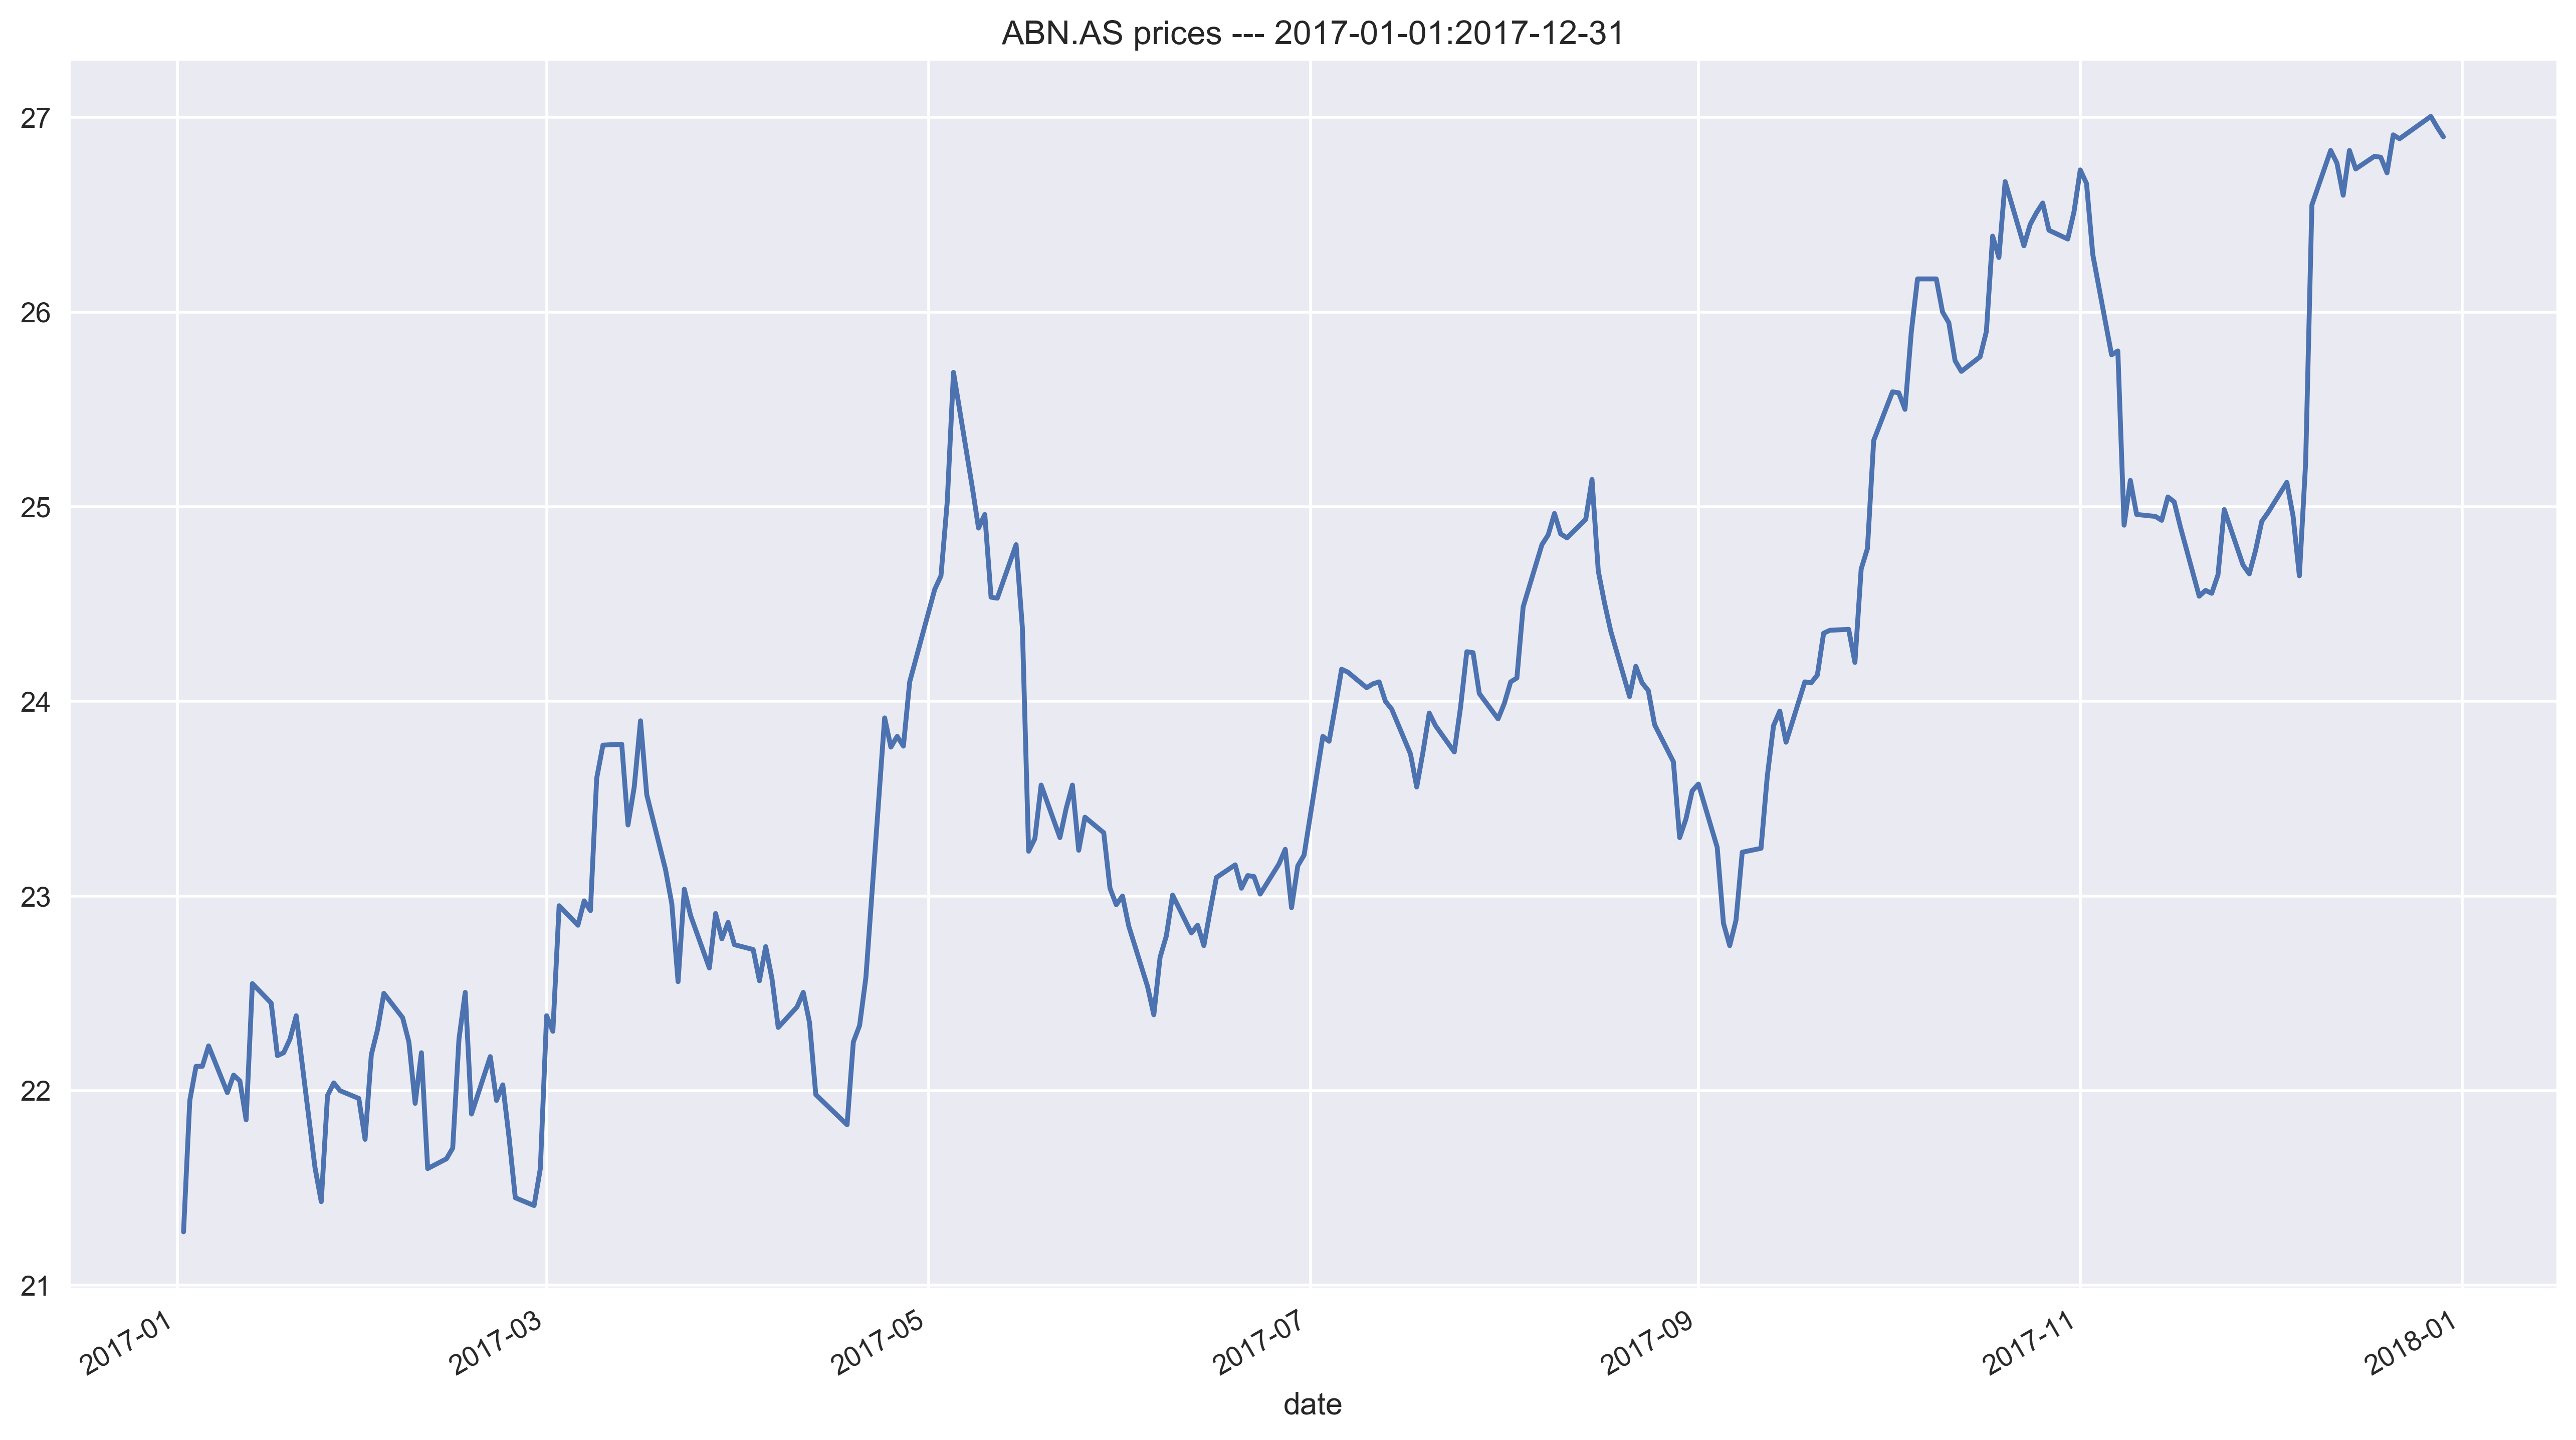

In [8]:
download_csv_data(ticker='ABN.AS', 
                  start_date='2017-01-01', 
                  end_date='2017-12-31', 
                  freq='daily', 
                  path='european/daily/abn.csv')

We also show the structure of the text file accepted by `zipline`.

In [36]:
!head ./european/daily/abn.csv

date,open,high,low,close,volume,dividend,split
2017-01-02,21.100000381469727,21.295000076293945,20.94499969482422,21.274999618530273,407919,0,1
2017-01-03,21.334999084472656,22.06999969482422,21.334999084472656,21.950000762939453,1453872,0,1
2017-01-04,21.989999771118164,22.135000228881836,21.934999465942383,22.125,1169976,0,1
2017-01-05,22.114999771118164,22.280000686645508,22.0,22.125,1102774,0,1
2017-01-06,22.100000381469727,22.25,22.045000076293945,22.229999542236328,766804,0,1
2017-01-09,22.21500015258789,22.219999313354492,21.93000030517578,21.989999771118164,1006061,0,1
2017-01-10,22.024999618530273,22.165000915527344,21.875,22.079999923706055,954217,0,1
2017-01-11,22.100000381469727,22.25,21.950000762939453,22.049999237060547,1140509,0,1
2017-01-12,21.90999984741211,22.104999542236328,21.829999923706055,21.850000381469727,1231540,0,1


And follow with the AEX index.

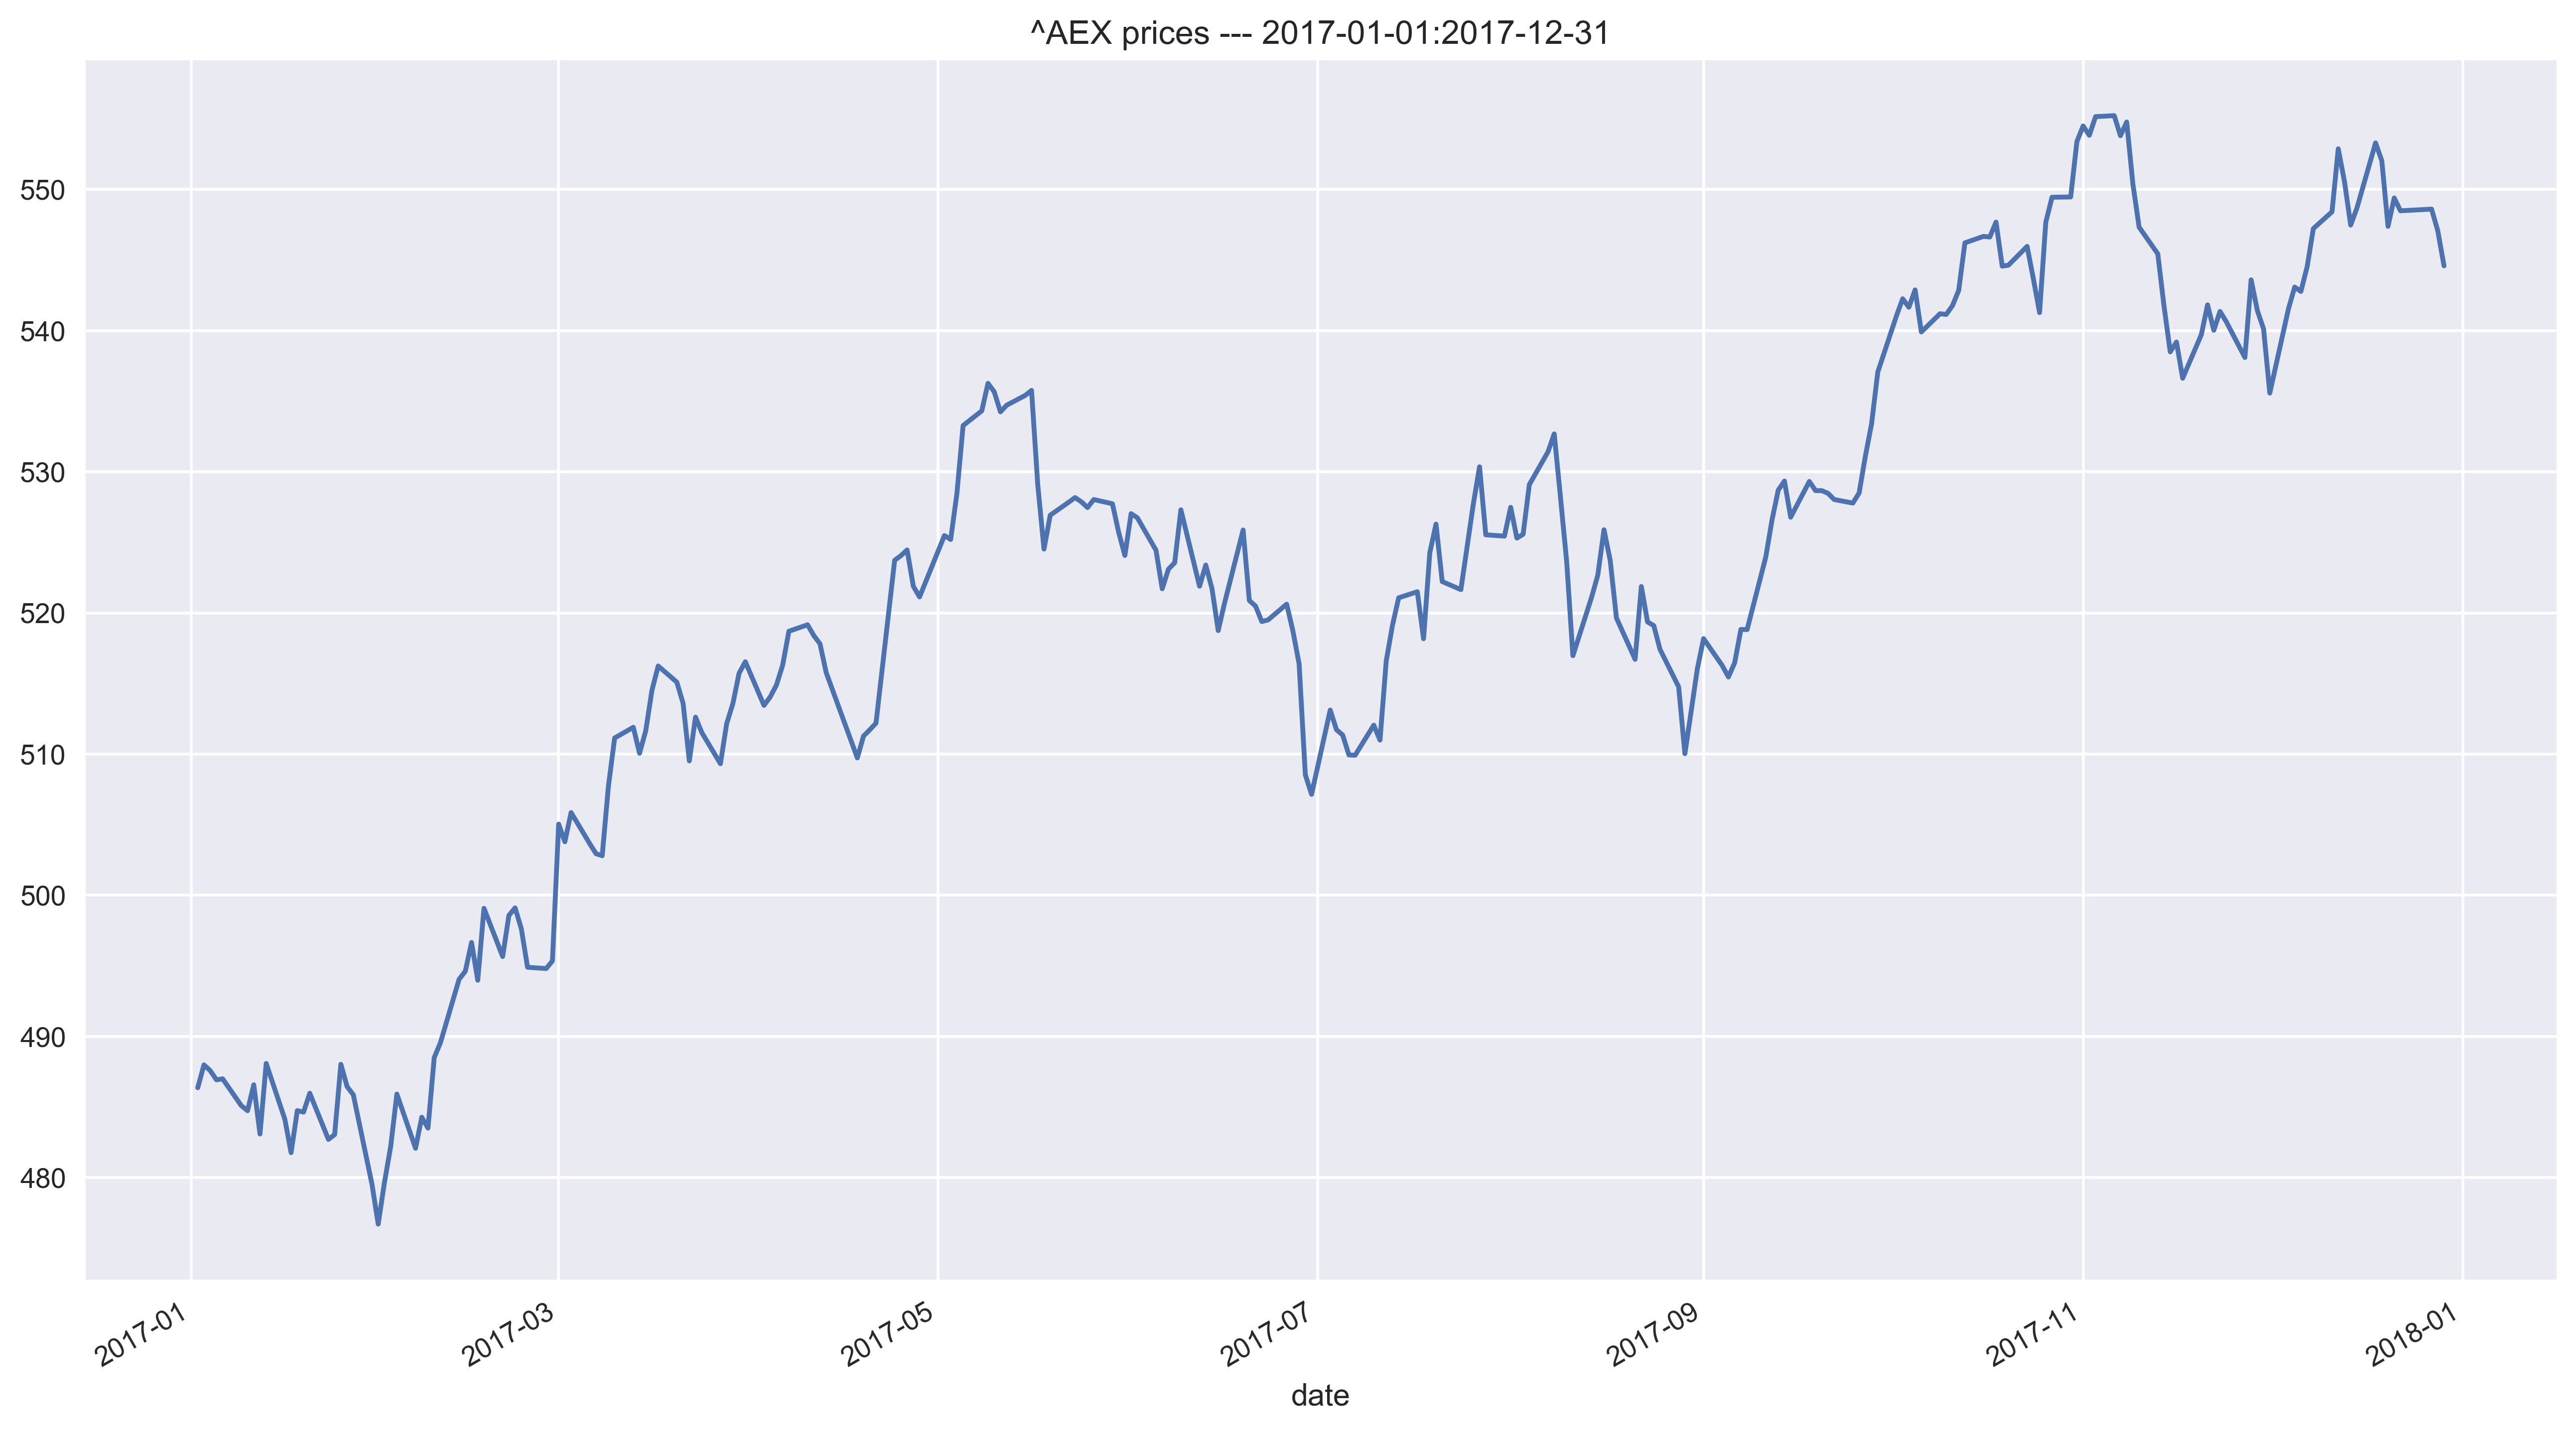

In [32]:
download_csv_data(ticker='^AEX', 
                  start_date='2017-01-01', 
                  end_date='2017-12-31', 
                  freq='daily', 
                  path='european/daily/aex.csv')

Let's inspect the currently loaded bundles:

In [9]:
!zipline bundles

csvdir <no ingestions>
eu_stocks <no ingestions>
quandl 2019-04-22 11:07:43.501513
quandl 2019-04-22 11:00:47.961243
quantopian-quandl <no ingestions>
us_stocks 2019-09-23 11:07:03.240901


We will now add a custom bundle called `eu_stocks`. To do so we need to modify the `extension.py` file located in the zipline directory. We need to add the following:

In [ ]:
start_session = pd.Timestamp('2017-01-02', tz='utc')
end_session = pd.Timestamp('2017-12-29', tz='utc')

# register the bundle
register(
    'eu_stocks',  # name we select for the bundle
    csvdir_equities(
        # name of the directory as specified above (named after data frequency)
        ['daily'],
        # path to directory containing the
        '/.../medium_articles/Quantitative Finance/european',
    ),
    calendar_name='XAMS',  # Euronext Amsterdam
    start_session=start_session,
    end_session=end_session
)

In contrast to the data downloading function, we need to pass the exact range of dates of the downloaded data. In this example, we start with `2017-01-02`, as this is the first day for which we have pricing data. 

Lastly, we run the following command to ingest the bundle:

In [21]:
!zipline ingest --bundle eu_stocks

Loading custom pricing data:   [##################------------------]   50% | abn: sid 0
Loading custom pricing data:   [####################################]  100% | aex: sid 1
Merging daily equity files:  [------------------------------------]  1
Merging daily equity files:  [####################################]   


And we verify that the bundle is indeed loaded:

In [22]:
!zipline bundles

csvdir <no ingestions>
eu_stocks 2019-09-23 15:02:20.627965
quandl 2019-04-22 11:07:43.501513
quandl 2019-04-22 11:00:47.961243
quantopian-quandl <no ingestions>


As one extra sanity check, we will inspect the contents of the loaded bundle, i.e., what securities are loaded and available for access.

In [23]:
import os
from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [24]:
from zipline.data import bundles

bundle = bundles.load('eu_stocks')
bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)

[Equity(0 [ABN]), Equity(1 [AEX])]

In [20]:
# !zipline clean --bundle eu_stocks --keep-last 0

## Buy And Hold Strategy

We start with the most basic strategy - Buy and Hold. The idea is that we buy a certain asset and do not do anything for the entire duration of the investment horizon. This simple strategy can also be considered a benchmark for more advanced ones - because there is no point in using a very complex strategy that generates less money (for example due to transaction costs) than buying and doing nothing.

In this example, we consider ABN AMRO's stock and select year 2017 as the duration of the backtest. We start with a capital of 250€. I selected this number as I know how much more or less we need to have for the initial purchase and I like to keep this number as small as possible because we are only buying 10 shares, so no need for a starting balance of a couple of thousands. Also, `zipline` by default works with US dollars, however, when all assets are in the same currency there is no problem with using stocks and indices quoted in euros. We assume no transaction costs (0.0€ per share, without a minimum cost per trade).

There are two approaches to using `zipline` - using the command line or Jupyter Notebook. To use the latter we have to write the algorithm within a Notebook cell and indicate that `zipline` is supposed to run it. This is done via the `%%zipline` IPython magic command. This magic takes the same arguments as the CLI mentioned above. 

Also one important thing, all imports required for the algorithm to run (such as `numpy`, `sklearn`, etc.) must be specified in the algorithm cell, even if they were previously imported elsewhere.

In [25]:
%%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o buy_and_hold.pkl --trading-calendar XAMS

# imports
from zipline.api import order, symbol, record, set_benchmark

# parameters
selected_stock = 'ABN'
n_stocks_to_buy = 10

def initialize(context):
    set_benchmark(symbol('AEX'))
    context.asset = symbol('ABN')
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 16:30:00+00:00,NaN,0.000000,NaN,0.010826,NaN,NaN,0.00000,250.00000,0.00,0.00,...,0.0,0.0,0,NaN,250.00000,0.00,0.00,1,[],0.0
2017-01-03 16:30:00+00:00,0.005377,-0.000479,-0.174350,0.014193,0.084132,0.063908,-219.61975,30.38025,219.50,219.50,...,0.0,0.0,0,-11.224972,250.00000,0.00,0.00,2,"[{'dt': 2017-01-03 16:30:00+00:00, 'amount': 1...",0.0
2017-01-04 16:30:00+00:00,0.066491,0.006521,1.131266,0.013341,0.093841,-0.521389,0.00000,30.38025,221.25,221.25,...,0.0,0.0,0,124.836530,30.38025,219.50,219.50,3,[],0.0
2017-01-05 16:30:00+00:00,0.056968,0.006521,0.626082,0.011990,0.089273,-0.284848,0.00000,30.38025,221.25,221.25,...,0.0,0.0,0,108.111606,30.38025,221.25,221.25,4,[],0.0
2017-01-06 16:30:00+00:00,0.052435,0.010681,0.734502,0.012137,0.079917,-0.322860,0.00000,30.38025,222.29,222.29,...,0.0,0.0,0,157.954187,30.38025,221.25,221.25,5,[],0.0
2017-01-09 16:30:00+00:00,0.088772,0.001081,-0.024659,0.008189,0.082406,0.212205,0.00000,30.38025,219.89,219.89,...,0.0,0.0,0,0.789670,30.38025,222.29,222.29,6,[],0.0
2017-01-10 16:30:00+00:00,0.083570,0.004681,0.127588,0.007438,0.076290,0.161802,0.00000,30.38025,220.79,220.79,...,0.0,0.0,0,2.999786,30.38025,219.89,219.89,7,[],0.0
2017-01-11 16:30:00+00:00,0.078082,0.003481,0.068195,0.011262,0.072269,0.123732,0.00000,30.38025,220.49,220.49,...,0.0,0.0,0,2.084812,30.38025,220.79,220.79,8,[],0.0
2017-01-12 16:30:00+00:00,0.085439,-0.004479,-0.167120,0.004009,0.081440,0.388791,0.00000,30.38025,218.50,218.50,...,0.0,0.0,0,-1.859323,30.38025,220.49,220.49,9,[],0.0
2017-01-13 16:30:00+00:00,0.164500,0.023481,0.187382,0.014401,0.091445,1.125972,0.00000,30.38025,225.49,225.49,...,0.0,0.0,0,9.567916,30.38025,218.50,218.50,10,[],0.0


Congrats, we have written our first backtest. So what actually happened?

Each `zipline` algorithm contains (at least) two functions we have to define:
* `initialize(context)` 
* `handle_data(context, data)`

Before the algorithm starts, the `initialize()` function is called and a `context` variable is passed. `context` is a global variable in which we can store additional variables we need to access from one iteration of the algorithm to the next. This is also where we need to change the benchmark to `AEX`, as the default one is SP500 traded on NYSE.

After the initialization of the algorithm, the `handle_data()` function is called once for each event. At every call, it passes the same `context` variable and an event frame called `data`. It contains the current trading bar with open, high, low, and close (OHLC) prices together with the volume.

We create an order by using `order(asset, number_of_units)`, where we specify what to buy and how many shares/units. A positive number indicates buying that many shares, 0 means selling everything we have, and a negative number is used for short-selling. Another useful type of order is `order_target`, which orders as many shares as needed to achieve the desired number in the portfolio.

In our Buy and Hold strategy, we check if we have already placed an order. If not, we order a given amount of shares and then do nothing for the rest of the backtest.

Let's analyze the performance of the strategy. First, we need to load the performance DataFrame from the pickle file.

In [31]:
# read the performance summary dataframe
buy_and_hold_results = pd.read_pickle('buy_and_hold.pkl')

And now we can plot some of the stored metrics:

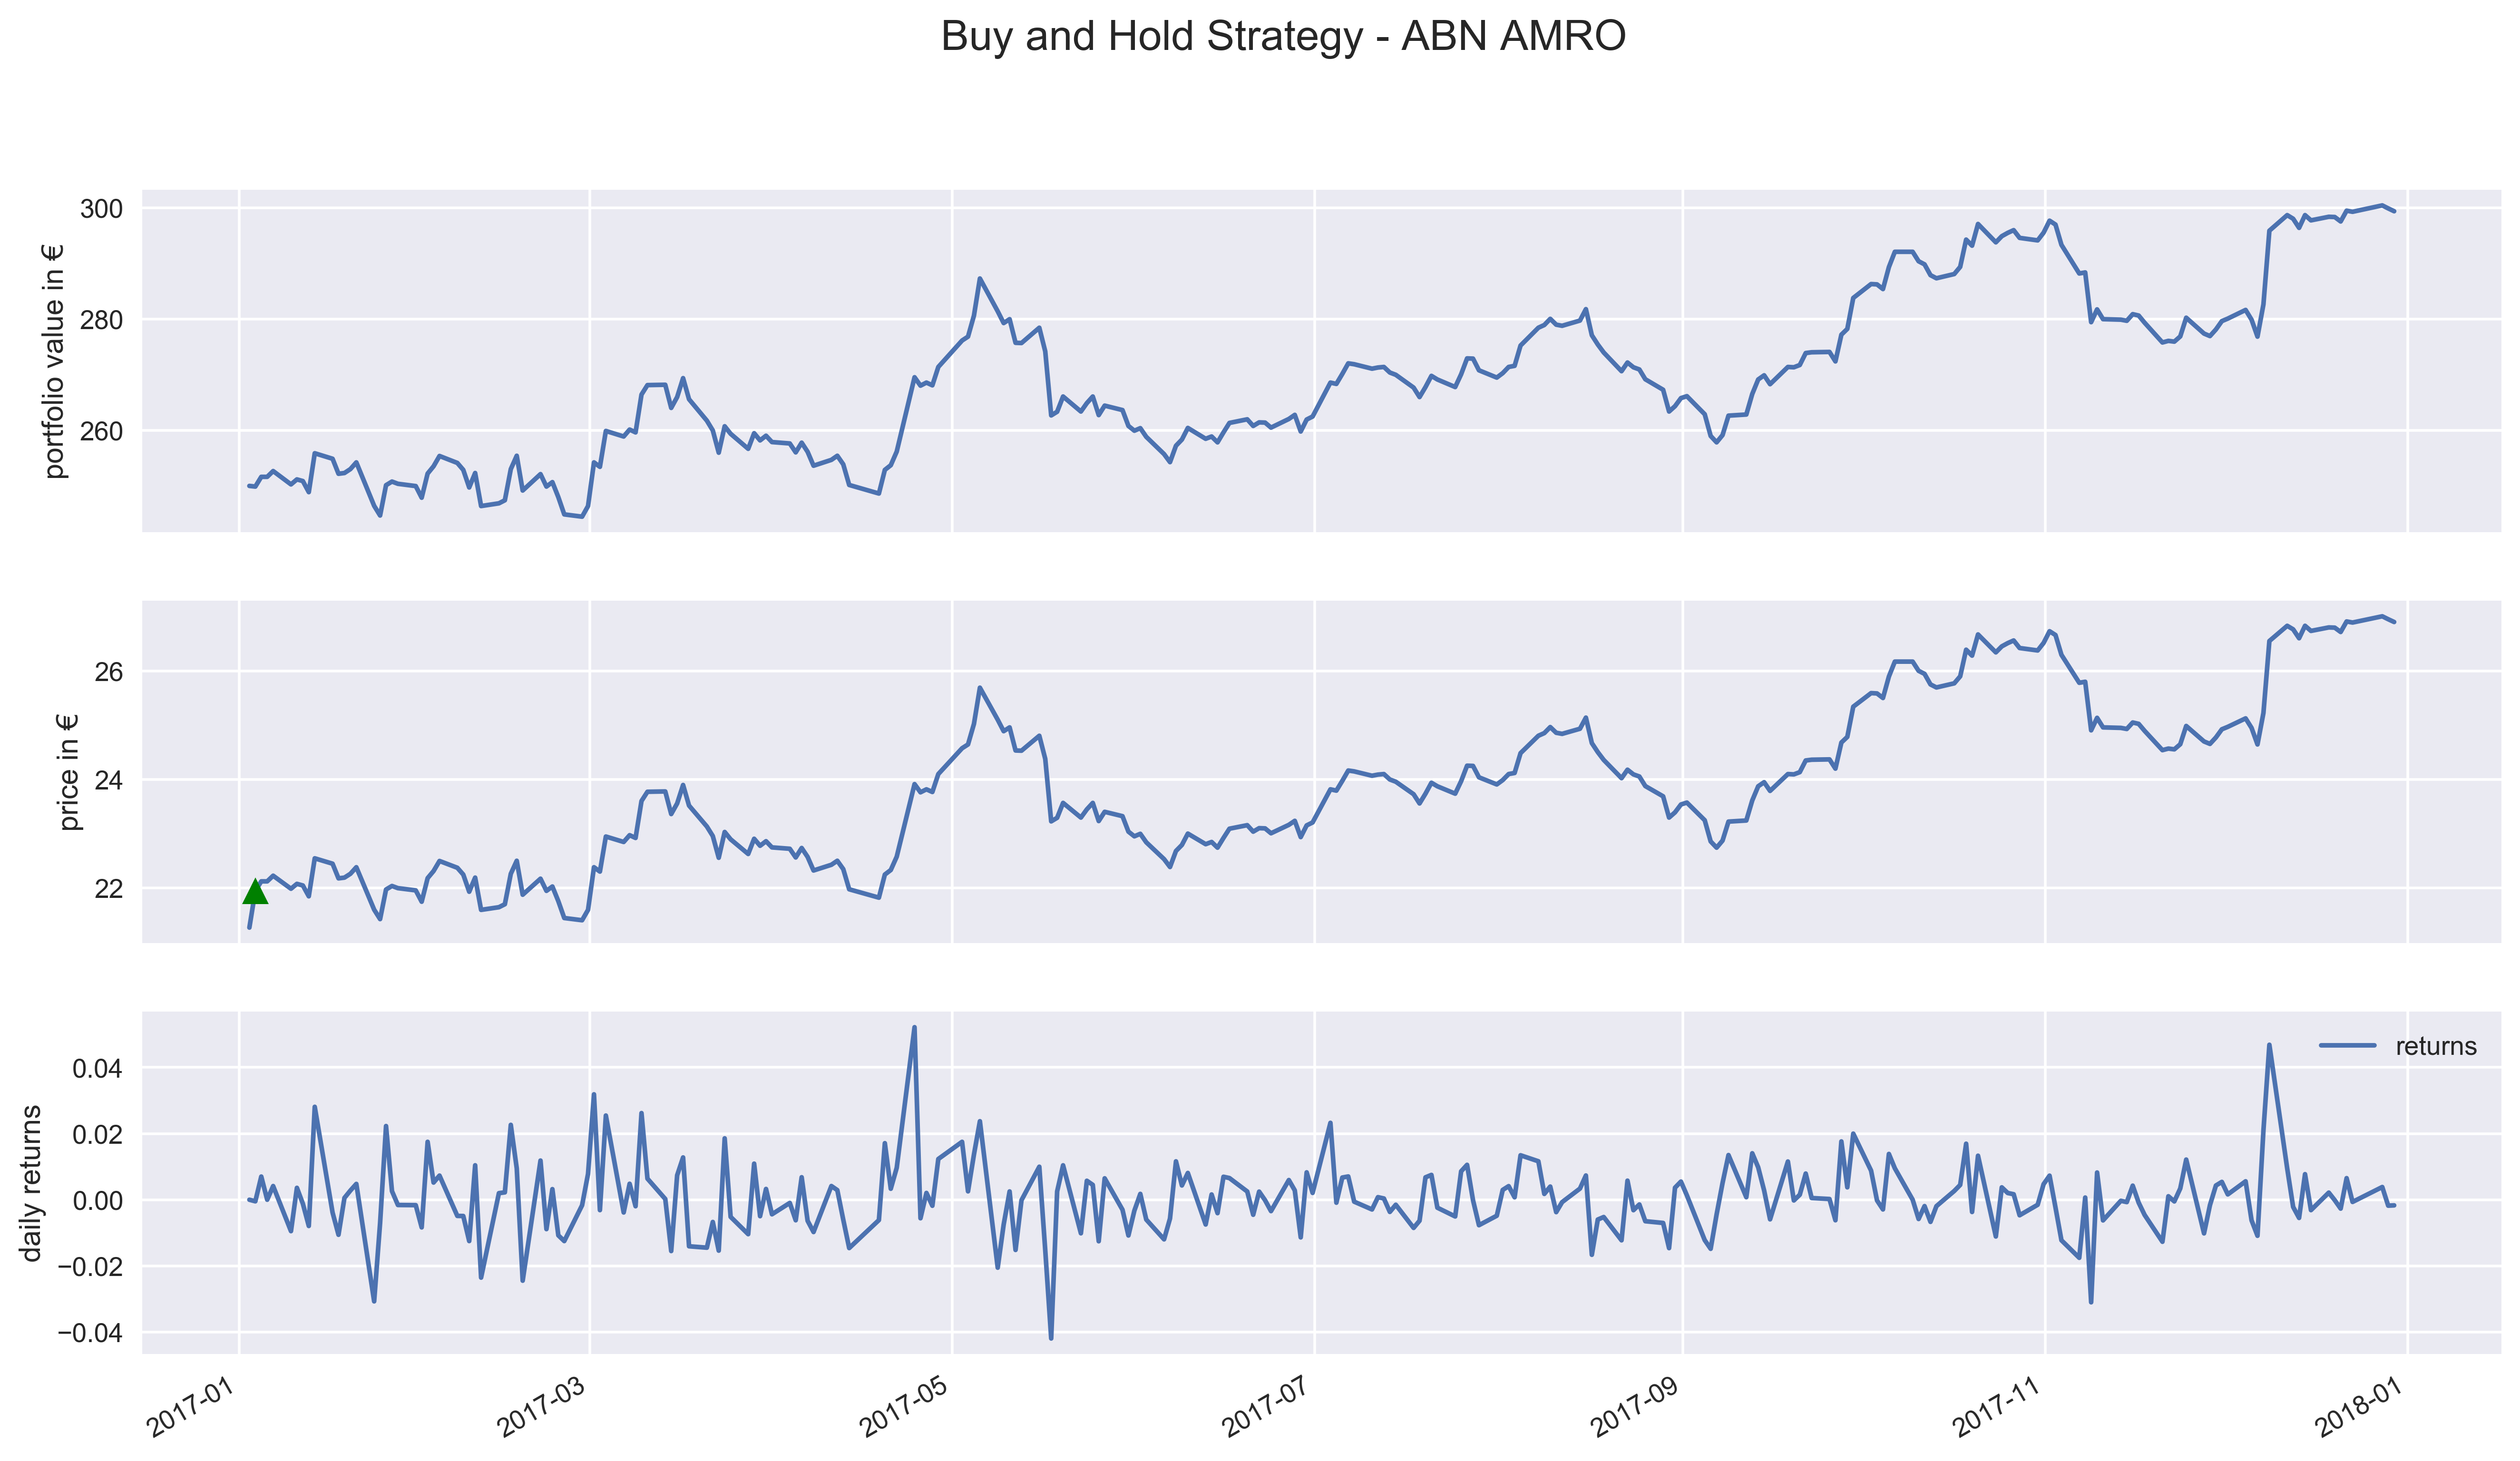

Final portfolio value (including cash): 299.37€


In [27]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

# portfolio value
buy_and_hold_results.portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('portfolio value in €')

# asset
buy_and_hold_results.price.plot(ax=ax[1])
ax[1].set_ylabel('price in €')

# mark transactions
perf_trans = buy_and_hold_results.loc[[t != [] for t in buy_and_hold_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax[1].plot(buys.index, buy_and_hold_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax[1].plot(sells.index, buy_and_hold_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

# daily returns
buy_and_hold_results.returns.plot(ax=ax[2])
ax[2].set_ylabel('daily returns')

fig.suptitle('Buy and Hold Strategy - ABN AMRO', fontsize=16)
plt.legend()
plt.show()

print('Final portfolio value (including cash): {}€'.format(np.round(buy_and_hold_results.portfolio_value[-1], 2)))

From the first look, we see that the portfolio generated money over the investment horizon and was very much following the price of ABN AMRO (what makes sense as it is the only asset in the portfolio).

To view the transactions we need to transform the `transactions` column from the performance `DataFrame`.

In [28]:
pd.DataFrame.from_records([x[0] for x in buy_and_hold_results.transactions.values if x != []])

,amount,commission,dt,order_id,price,sid
0,10,None,2017-01-03 16:30:00+00:00,f69387232c574779a0188f9f7454b63f,21.960975,Equity(0 [ABN])


By inspecting the columns of the performance `DataFrame` we can see all the available metrics.

In [29]:
buy_and_hold_results.columns

Index(['algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'price', 'returns', 'sharpe', 'short_exposure',
       'short_value', 'shorts_count', 'sortino', 'starting_cash',
       'starting_exposure', 'starting_value', 'trading_days', 'transactions',
       'treasury_period_return'],
      dtype='object')

Some of the noteworthy ones:
* starting/ending cash - inspecting the cash holding on a given day
* starting/ending value - inspecting the assets; value on a given day
* orders - used for inspecting orders; there are different events for creating an order when the trading strategy generates a signal, and a separate one when it is actually executed on the next trading day
* pnl - daily profit and loss

## Simple Moving Average Strategy

The second strategy we consider is based on the simple moving average (SMA). The 'mechanics' of the strategy can be summarized by the following:

* when the price crosses the 20-day SMA upwards - buy x shares
* when the price crosses the 20-day SMA downwards - sell the shares
* we can only have a maximum of x shares at any given time
* there is no short-selling in the strategy (though it can be easily implemented)

The remaining components of the backtest like the considered asset, investment horizon or the starting capital is the same as in the Buy and Hold example.

/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/eryklewinson/anaconda3/envs/env_zipline2/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


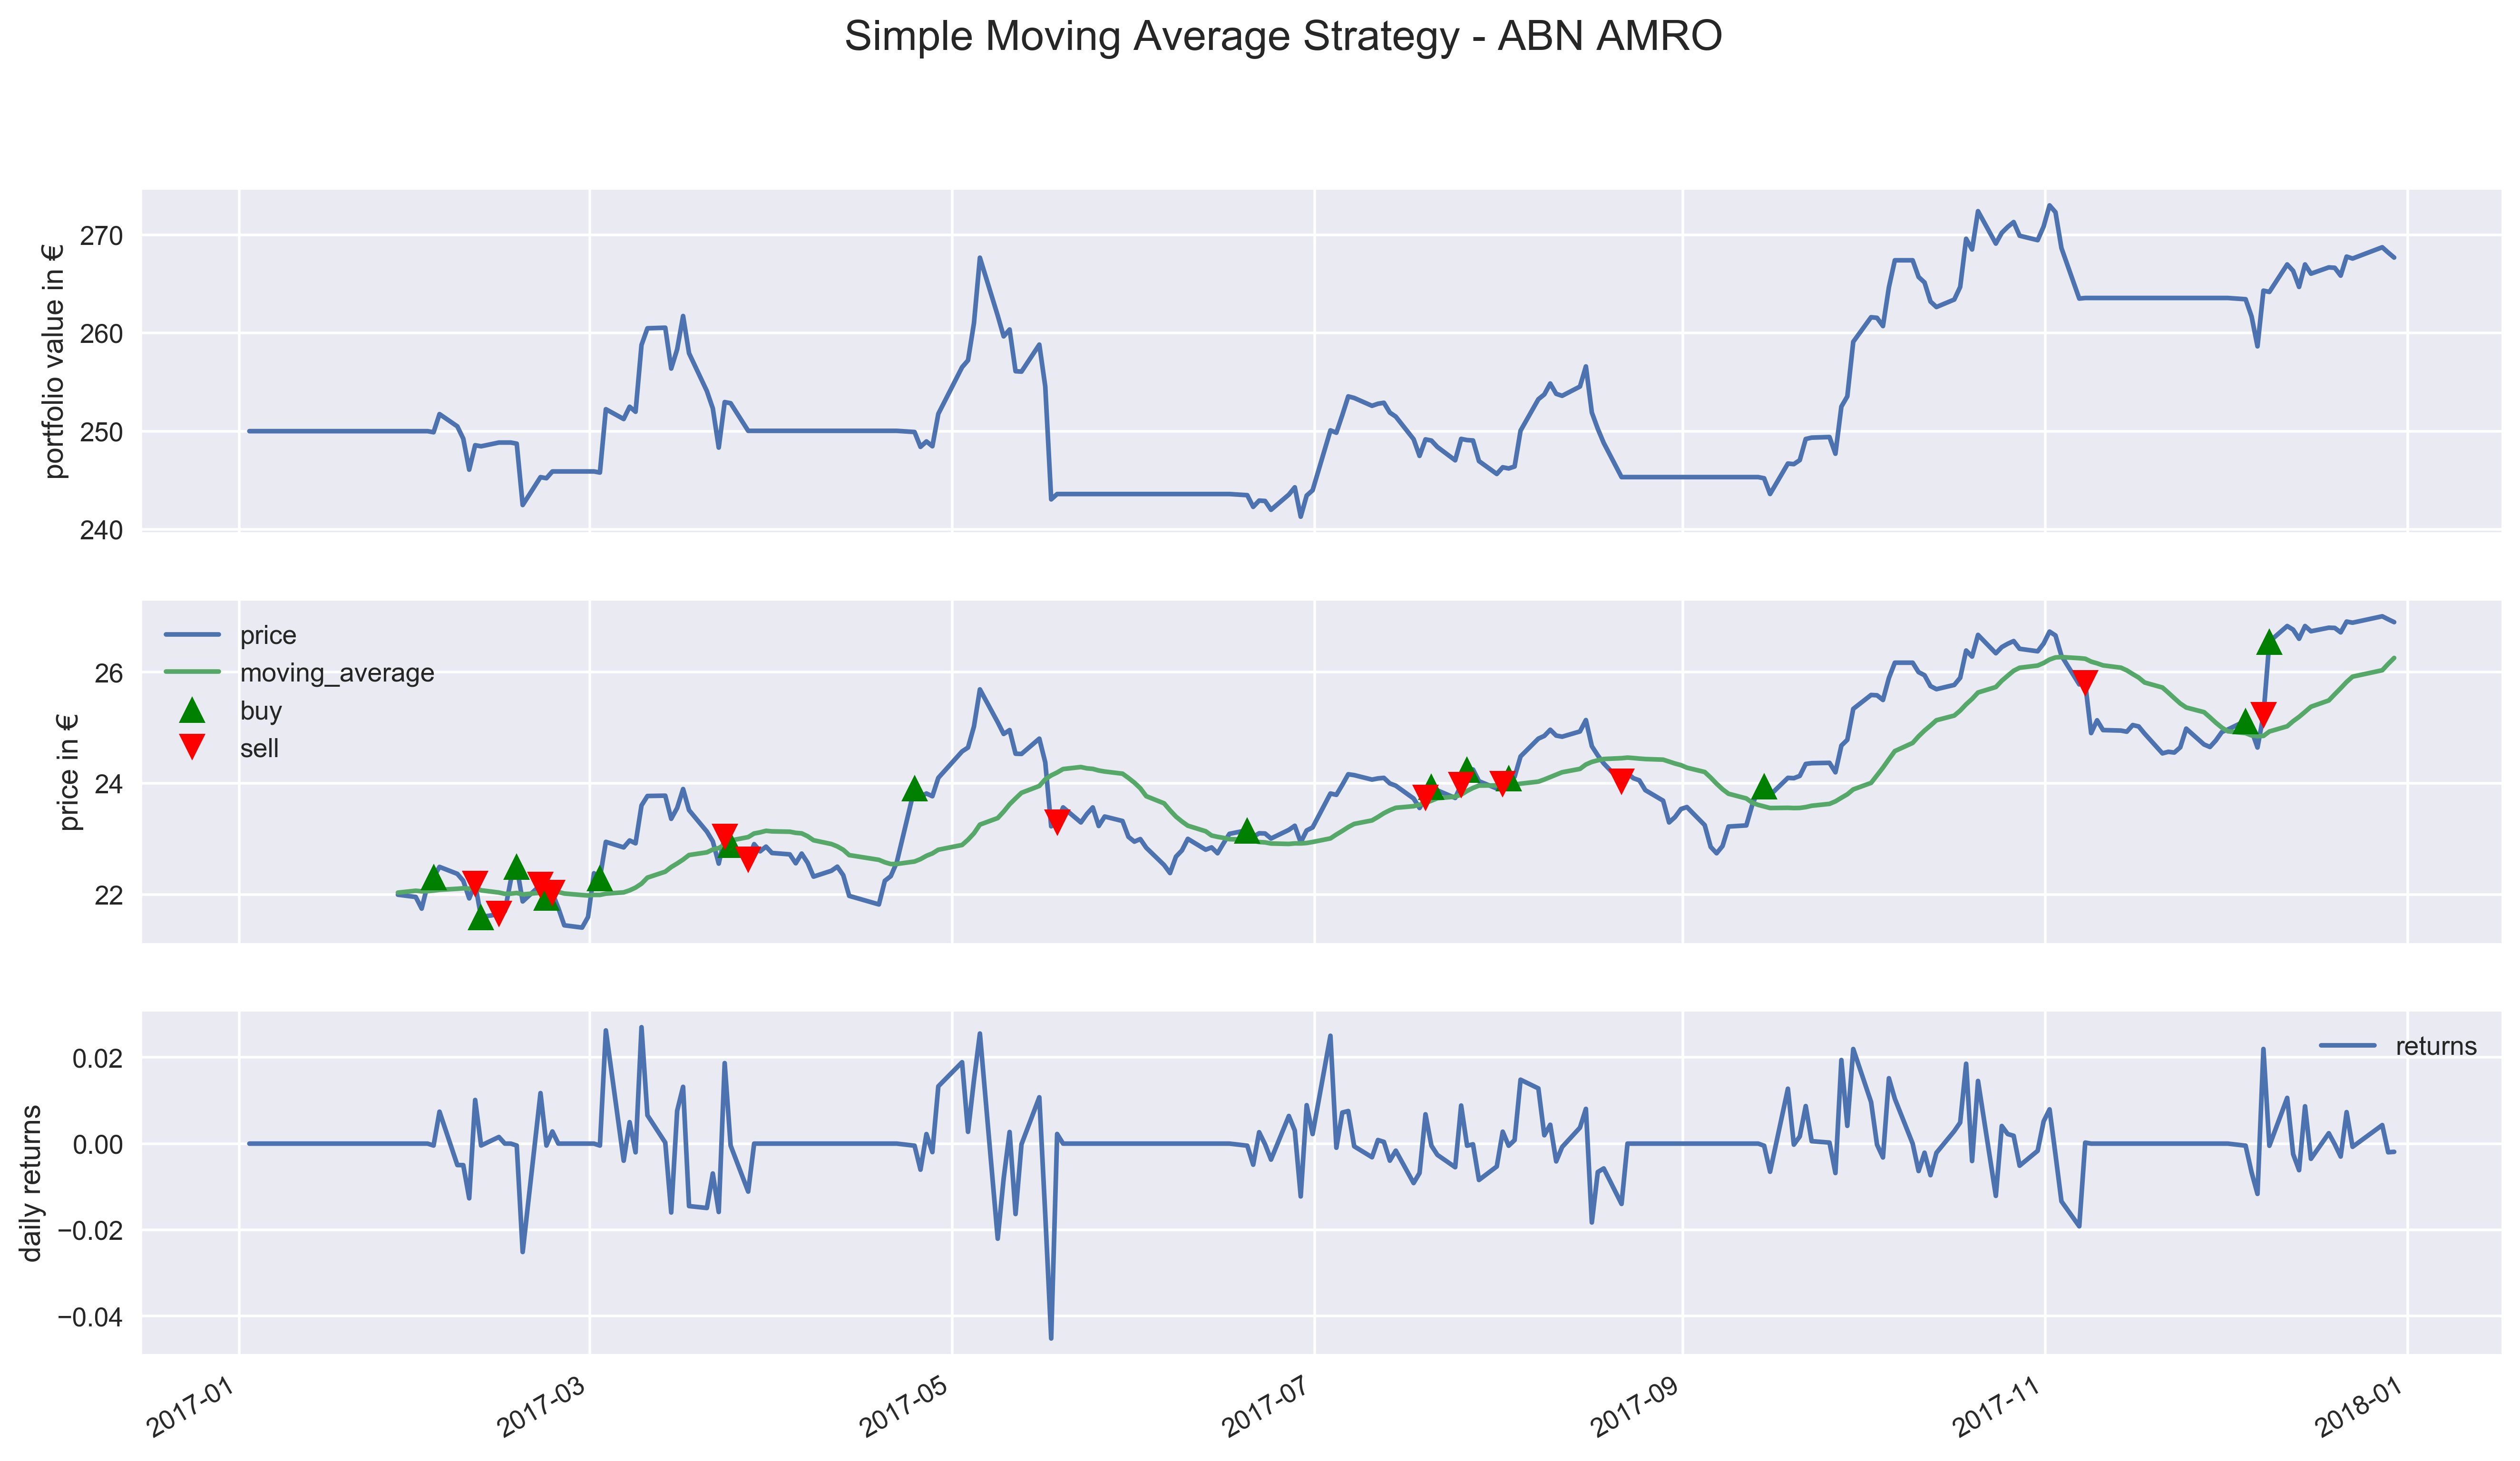

Final portfolio value (including cash): 267.68€


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 16:30:00+00:00,NaN,0.000000,NaN,0.010826,NaN,NaN,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,1,[],0.0
2017-01-03 16:30:00+00:00,0.000000,0.000000,0.000000,0.014193,0.084132,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,2,[],0.0
2017-01-04 16:30:00+00:00,0.000000,0.000000,0.000000,0.013341,0.093841,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,3,[],0.0
2017-01-05 16:30:00+00:00,0.000000,0.000000,0.000000,0.011990,0.089273,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,4,[],0.0
2017-01-06 16:30:00+00:00,0.000000,0.000000,0.000000,0.012137,0.079917,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,5,[],0.0
2017-01-09 16:30:00+00:00,0.000000,0.000000,0.000000,0.008189,0.082406,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,6,[],0.0
2017-01-10 16:30:00+00:00,0.000000,0.000000,0.000000,0.007438,0.076290,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,7,[],0.0
2017-01-11 16:30:00+00:00,0.000000,0.000000,0.000000,0.011262,0.072269,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,8,[],0.0
2017-01-12 16:30:00+00:00,0.000000,0.000000,0.000000,0.004009,0.081440,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,9,[],0.0
2017-01-13 16:30:00+00:00,0.000000,0.000000,0.000000,0.014401,0.091445,0.000000,0.000000,250.000000,0.00,0.00,...,0.0,0.0,0,NaN,250.000000,0.00,0.00,10,[],0.0


In [31]:
%%zipline --start 2017-1-2 --end 2017-12-29 --capital-base 250 --bundle eu_stocks -o sma_strategy.pkl --trading-calendar XAMS

# imports 
from zipline.api import order_target, record, symbol, set_benchmark
from zipline.finance import commission
import matplotlib.pyplot as plt
import numpy as np

# parameters 
ma_periods = 20
selected_stock = 'ABN'
n_stocks_to_buy = 10

def initialize(context):
    context.time = 0
    context.asset = symbol(selected_stock)
    set_benchmark(symbol('AEX'))
    # 1. manually setting the commission
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    # 2. warm-up period
    context.time += 1
    if context.time < ma_periods:
        return

    # 3. access price history
    price_history = data.history(context.asset, fields="price", bar_count=ma_periods, frequency="1d")
 
    # 4. calculate moving averages
    ma = price_history.mean()
    
    # 5. trading logic
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma):
        order_target(context.asset, n_stocks_to_buy)
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma):
        order_target(context.asset, 0)

    # save values for later inspection
    record(price=data.current(context.asset, 'price'),
           moving_average=ma)
    
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

    # portfolio value
    perf.portfolio_value.plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in €')
    
    # asset
    perf[['price', 'moving_average']].plot(ax=ax[1])
    ax[1].set_ylabel('price in €')
    
    # mark transactions
    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
    ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
    ax[1].legend()
    
    # daily returns
    perf.returns.plot(ax=ax[2])
    ax[2].set_ylabel('daily returns')

    fig.suptitle('Simple Moving Average Strategy - ABN AMRO', fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}€'.format(np.round(perf.portfolio_value[-1], 2)))


The code for this algorithm is a little bit more complex, but we will cover all the new aspects of the code. For simplicity, I marked the points of reference in the code snippet above and will refer to them by number below.

1. I show how to manually set the commission. In this case, I use the default value for comparison's sake.
2. The "warm-up period" - this is a trick used in order to make sure that the algorithm has enough days to calculate the moving average. If we are using multiple metrics with different window lengths, we should always take the longest one for the warm-up. 
3. We access the historical (and current) data-points by using `data.history`. In this example, we access the last 20 days. The data (in case of a single asset) is stored as a `pandas.Series`, indexed by time.
4. The SMA is a very basic measure, so for calculation, I simply take the mean of the previously accessed data.
5. I encapsulate the logic of the trading strategy in an `if` statement. To access the current and previous data-points I use `price_history[-2]` and `price_history[-1]`, respectively. To see if there was a crossover, I compare the current and previous prices to the MA and determine which case I am dealing with (buy/sell signal). In the case where there is no signal, the algorithm does nothing.
6. You can use the `analyze(context, perf)` statement to carry out extra analysis (like plotting) when the backtest is finished. The `perf` object is simply the performance `DataFrame` we also store in a pickle file. But when used withing the algorithm, we should refer to it as `perf` and there is no need for loading it.

As compared to the Buy and Hold strategy, you might have noticed the periods where the portfolio value is flat. That is because when we sell the asset (and before buying again), we only hold cash.

In our case, the Buy and Hold strategy outperformed the Simple Moving Average one. The ending worth of the portfolio (including cash) is 299.37€ for the B&H strategy, while it is 267.68€ in case of the more complex one.

## Conclusions

In this article, I have shown how to use the `zipline` framework to carry out the backtesting of trading strategies. Once you get familiar with the library, it is easy to test out different strategies. In a future article, I will cover using more advanced trading strategies based on technical analysis. 